In [31]:
import bisect
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../data/data_engineered.csv')

In [3]:
df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time'])

In [4]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

Preprocessing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [6]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [7]:
categorical_cols

Index(['merchant', 'category', 'gender'], dtype='object')

In [8]:
numerical_cols

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'dist_between_client_and_merch',
       'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant',
       'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month',
       'times_shopped_at_merchant_day', 'time_diff_seconds', 'trans_per_hour',
       'hour_trans_ratio', 'unusual_distance', 'distance_diff',
       'velocity_km_h', 'mean_dist_merchant', 'std_dist_merchant',
       'dist_z_score', 'amt_month_ratio', 'amt_year_ratio',
       'mean_amt_category', 'std_amt_category', 'amt_z_score',
       'high_amt_first_time', 'mean_times_day_merchant',
       'std_times_day_merchant', 'times_day_z_score', 'fraud_rate_merchant',
       'unique_cards_per_hour', 'amt_variance_hour'],
      dtype='object')

In [9]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

In [10]:
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data and transform both train and test
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str)) # Ensure string type

    # Handle new/unseen categories in test data
    # Map them to a placeholder that will be included in the encoder's classes
    X_test_processed[col] = X_test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    if '<unknown>' not in le.classes_:
        # Add '<unknown>' to the LabelEncoder's classes if it's not already there
        # and it appeared in the test set after mapping
        if X_test_processed[col].eq('<unknown>').any():
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '<unknown>') # Keep sorted for consistency
            le.classes_ = np.array(le_classes)
        
    X_test_processed[col] = le.transform(X_test_processed[col])

## Primer Intento

Definimos los parámetros para nuestro modelo

In [ ]:
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    objective='binary',
    random_state=123,
    n_jobs=2,
    is_unbalance=True
)

Entrenamos el modelo que definimos con la data de entrenamiento

In [12]:
lgbm_classifier.fit(X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 6811, number of negative: 1289864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7087
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005253 -> initscore=-5.243753
[LightGBM] [Info] Start training from score -5.243753


LGBMClassifier(is_unbalance=True, n_jobs=2, objective='binary',
               random_state=123)

Obtenemos las predicciones del modelo entrenado utilizando los datos de prueba

In [13]:
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]

Comparamos los resultados de las predicciones

LightGBM Model Evaluation:


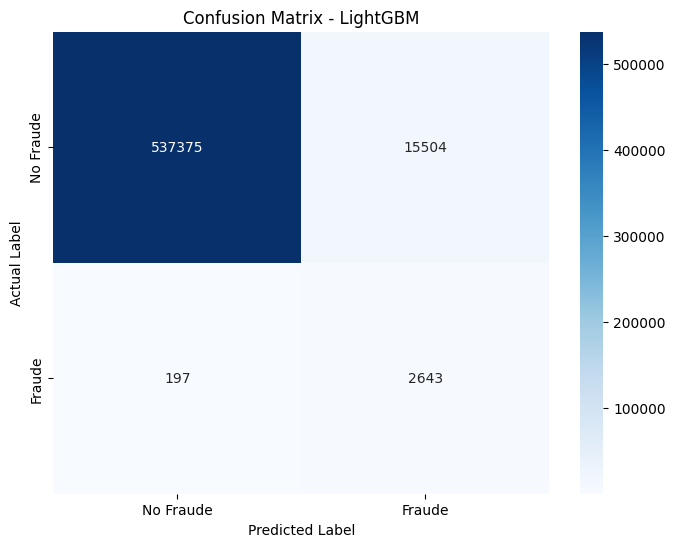

In [38]:
print("LightGBM Model Evaluation:")
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


En la gráfica se puede ver que nuestro modelo es muy bueno sabiendo cuando una transacción es no fraude, sin embargo, se puede ver que también tiende a confundir algunas transacciones como fraude cuando no lo son. cuando vemos la clasificación de las transacciones fraudulentas, podemos ver que nuestras si lográ identificar un 93% de las transacciones fraudulentas, lo cual es menos del 7% para errores de tipo 2. En cambio, cuando miramos los errores de tipo 1, se puede ver que nuestro modelo no parece reconocer muy bien los fraudes, ya que nos devuelve muchas transacciones legítimas como fraudulentas.

In [17]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Not Fraud', 'Fraud']))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score:")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.99    552879
       Fraud       0.15      0.93      0.25      2840

    accuracy                           0.97    555719
   macro avg       0.57      0.95      0.62    555719
weighted avg       1.00      0.97      0.98    555719


ROC AUC Score:
0.9508250741973977

F1 Score:
0.9818516398969912


In [18]:
print("\nFeature Importances (LightGBM):")
importances = lgbm_classifier.feature_importances_
feature_names = X_train_processed.columns
sorted_indices = np.argsort(importances)[::-1]

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature Importances (LightGBM):
amt_z_score: 311
amt: 276
hour_trans_ratio: 224
mean_times_day_merchant: 171
amt_year_ratio: 162
amt_month_ratio: 155
fraud_rate_merchant: 144
hour: 138
std_times_day_merchant: 120
amt_month_shopping_net_spend: 115
amt_year: 88
time_diff_seconds: 87
amt_month: 85
times_day_z_score: 84
cc_num: 63
amt_variance_hour: 58
velocity_km_h: 52
merchant: 51
distance_diff: 47
mean_dist_merchant: 47
std_dist_merchant: 44
category: 42
zip: 41
count_month_shopping_net: 38
times_shopped_at_merchant: 36
lat: 36
dist_between_client_and_merch: 35
mean_amt_category: 33
merch_lat: 30
trans_per_hour: 26
long: 24
trans_month: 24
std_amt_category: 19
dist_z_score: 18
times_shopped_at_merchant_year: 18
merch_long: 17
trans_day: 15
gender: 6
times_shopped_at_merchant_month: 6
unique_cards_per_hour: 5
times_shopped_at_merchant_day: 4
high_amt_first_time: 2
first_time_at_merchant: 2
year: 1
unusual_distance: 0


Imprimimos las features más importantes dentro de las predicciones del modelo

## Métricas Personalizadas

### Métrica para error en general

In [32]:
# Función feval personalizada para la tasa de error de clasificación
def custom_error(preds, dataset):
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    # Convertimos las predicciones a clases (umbral 0.5 para clasificación binaria)
    preds_binary = np.where(preds > 0.5, 1, 0)
    # Calculamos la tasa de error
    error = np.mean(preds_binary != labels)
    # Devolver una tupla: (nombre_métrica, valor_métrica, es_mayor_mejor)
    return 'custom_error', error, False  # Colocamos False porque un error menor es mejor

# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

# Configurar parámetros
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31
}

# Entrenar el modelo con la métrica personalizada
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_error # Colocamos nuestra función de evaluación personalizada
)

[LightGBM] [Info] Number of positive: 6811, number of negative: 1289864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7089
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005253 -> initscore=-5.243753
[LightGBM] [Info] Start training from score -5.243753


In [34]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved = model.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved = np.where(y_pred_improved > 0.5, 1, 0)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred_binary_improved)
auc = roc_auc_score(y_test, y_pred_improved)
f1_score = f1_score(y_test, y_pred_binary_improved, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.9985
AUC: 0.9967
F1 Score: 0.9985


LightGBM Model Evaluation:


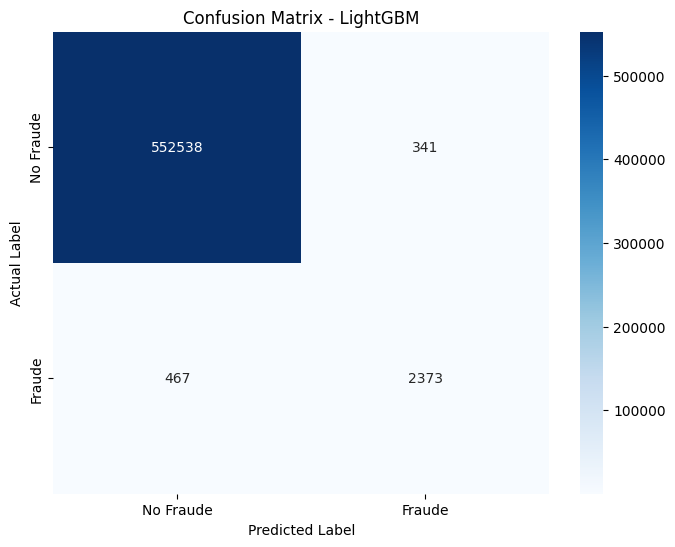

In [40]:
cm = confusion_matrix(y_test, y_pred_binary_improved)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()